# Importing the relevant libraries

In [20]:
# Importing the relevant libraries
import numpy as np
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import json
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Flatten
from keras.layers import Input, Concatenate
from keras.models import Model

In [21]:
from tqdm import tqdm
import re
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [22]:
# Load and preprocess the sneaker images
SIZE = 128
_img = []
path = '/sneakers1_images/sneakers1_images/'
files = os.listdir(path)
files = sorted(files)
for i in files:
    img = cv2.imread(path + i)
    if img is None:
        print(f"Image '{i}' not found.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = (img - 127.5) / 127.5
    _img.append(img)

Image '.ipynb_checkpoints' not found.


## Visualise the images

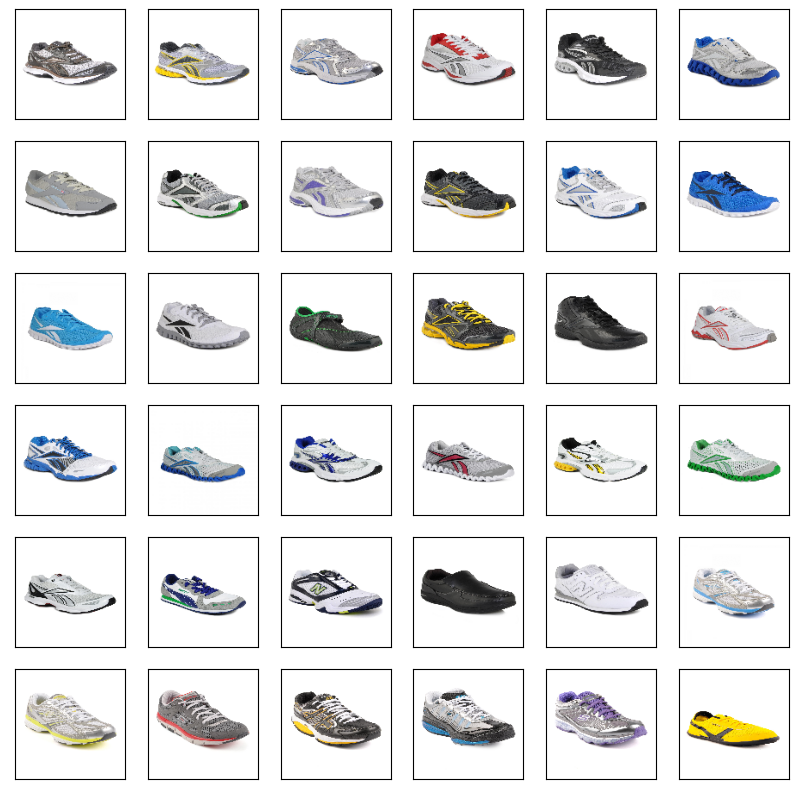

In [23]:
# Visualize the images
# Define the plot_images function
def plot_images(sqr=5):
    plt.figure(figsize=(10, 10))
    plt.title("Real Images", fontsize=35)
    for i in range(sqr * sqr):
        plt.subplot(sqr, sqr, i+1)
        plt.imshow(_img[i] * 0.5 + 0.5)
        plt.xticks([])
        plt.yticks([])

# Check if the _img list is not empty
if len(_img) > 0:
    # Call the plot_images function
    plot_images(6)
else:
    print("No images found or an error occurred during image processing.")


In [24]:
# Convert the image data to a NumPy array
image_data = np.array(_img)

# Define the batch size for training
batch_size = 32


In [25]:
# Create a TensorFlow dataset from the image data
dataset = tf.data.Dataset.from_tensor_slices(image_data).batch(batch_size)

## Generator

In [26]:
# Generator
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128 * 128 * 3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128, 128, 3)))
    model.add(tf.keras.layers.Conv2D(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3, 4, strides=1, padding='same', activation='tanh'))
    return model

In [27]:
# Create the generator
generator = Generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 49152)             4915200   
                                                                 
 reshape_1 (Reshape)         (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)     6144      
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                      

## Discriminator

In [28]:
# Discriminator
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [29]:
# Create the discriminator
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 128)      

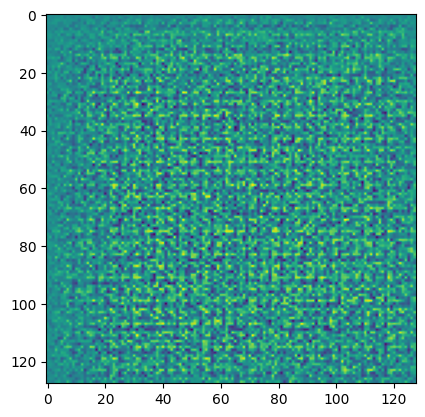

In [30]:
# Plot generated images before training
noise = np.random.normal(-1, 1, (1, latent_dim))
img = generator(noise)
plt.imshow(img[0, :, :, 0])
plt.show()

## Defining optimizer and loss function

In [31]:


# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.0001,
    clipvalue=1.0
)

# Define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator loss function
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss



## Defining training steps

In [32]:
# Define training steps
def train_steps(images):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)

    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss': gen_loss,
            'disc loss': disc_loss}
    return loss

## Defining function to plot generated images

In [33]:
# Function to plot generated images
def plot_generated_images(square=5, epochs=0):
    plt.figure(figsize=(10, 10))
    for i in range(square * square):
        if epochs != 0:
            if (i == square // 2):
                plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize=32, color='black')
        plt.subplot(square, square, i + 1)
        noise = np.random.normal(0, 1, (1, latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0, ...] + 1) / 2, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()

## Compiling the generator and discriminator models

In [34]:
# Compile the generator and discriminator models
generator.compile(optimizer=optimizer, loss=generator_loss, metrics=['accuracy'])
discriminator.compile(optimizer=optimizer, loss=discriminator_loss, metrics=['accuracy'])

## Training

In [35]:
import time
gen_losses = []
disc_losses = []

# Training
def train(epochs, dataset):
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
            gen_losses.append(loss['gen loss'])
            disc_losses.append(loss['disc loss'])
        print("Time: {}".format(np.round(time.time() - start), 2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'], loss['disc loss']))
            

    # Plot generator and discriminator losses against epochs
    plt.plot(range(1, len(gen_losses) + 1), gen_losses, label='Generator Loss')
    plt.plot(range(1, len(disc_losses) + 1), disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Training the GAN on sneakers images


Epoch : 1
Time: 23.0
Generator Loss: 0.18560561537742615 Discriminator Loss: 2.1583237648010254

Epoch : 2
Time: 23.0
Generator Loss: 0.9683030843734741 Discriminator Loss: 1.175684928894043

Epoch : 3
Time: 23.0
Generator Loss: 0.8263742923736572 Discriminator Loss: 1.3152234554290771

Epoch : 4
Time: 23.0
Generator Loss: 1.5707764625549316 Discriminator Loss: 1.0441627502441406

Epoch : 5
Time: 23.0
Generator Loss: 0.6987811326980591 Discriminator Loss: 1.2925751209259033

Epoch : 6
Time: 23.0
Generator Loss: 0.6996104717254639 Discriminator Loss: 1.2201273441314697

Epoch : 7
Time: 23.0
Generator Loss: 0.3813142776489258 Discriminator Loss: 1.5662943124771118

Epoch : 8
Time: 23.0
Generator Loss: 0.6087936162948608 Discriminator Loss: 1.3587868213653564

Epoch : 9
Time: 23.0
Generator Loss: 0.6398261189460754 Discriminator Loss: 1.0110419988632202

Epoch : 10
Time: 23.0
Generator Loss: 0.2901802062988281 Discriminator Loss: 1.4867851734161377

Epoch : 11
Time: 23.0
Generator Loss: 

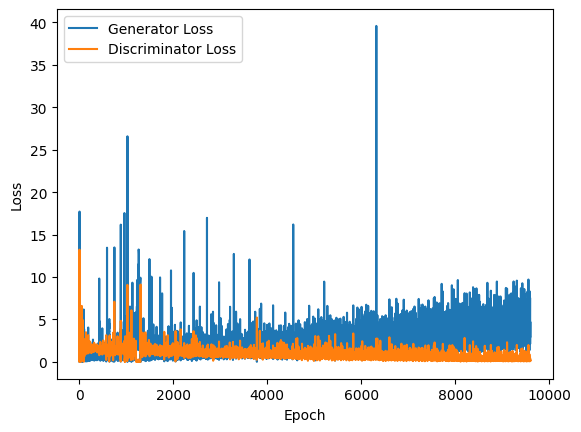

In [37]:
# Training the GAN on fashion product images
train(150, dataset)

## Plotting Generated Sneakers Images

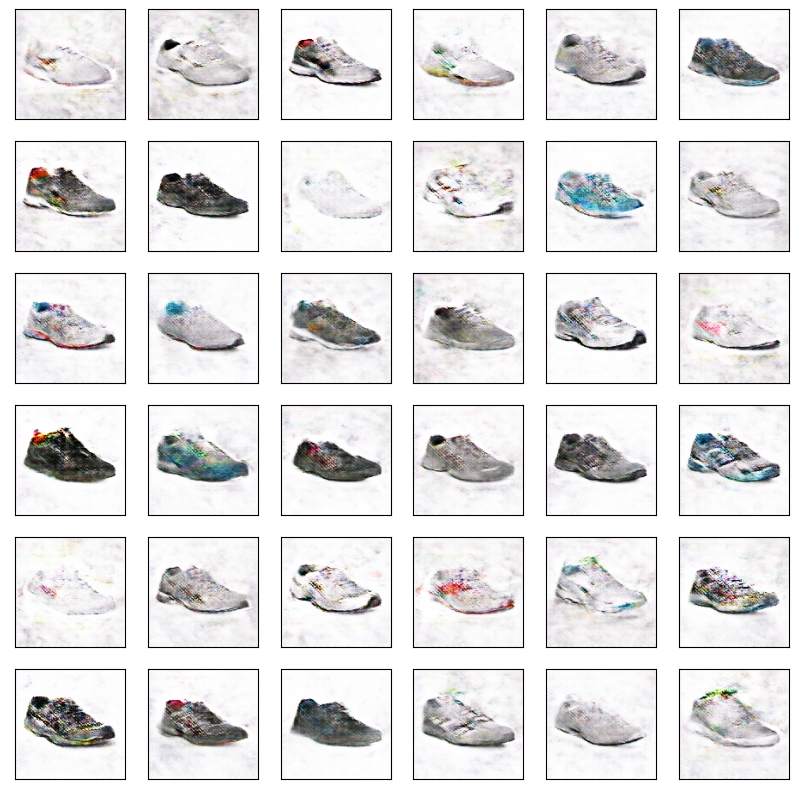

In [38]:
# Plot generated sneakers images
plot_generated_images(6)

## Saving the Generator and Discriminator Model

In [40]:
generator.save('sneakerss.h5')
discriminator.save('dsneakerss.h5')